In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import gridspec
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
from datetime import datetime, timedelta
import calendar
import os
import warnings
from IPython.display import HTML
import torch
import torch.nn as nn

# scikit-learn imports
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error, r2_score, accuracy_score, precision_score, 
    recall_score, f1_score, roc_auc_score, average_precision_score, 
    brier_score_loss, precision_recall_curve
)
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF, WhiteKernel, RationalQuadratic, ExpSineSquared, ConstantKernel
)
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression

# Other utilities
from scipy.spatial import cKDTree
import joblib

warnings.filterwarnings('ignore')

csv_path = "UpdatedDisasterDeclarationSummariesPlusLocation_RowColFiltered.csv"
grid_size = 0.5 # resolution of grid
prediction_months = 12
max_training_samples = 5000
disaster_types = ["storm", "flood", "rain", "ice", "snow", "blizzard", "hurricane"]

Load and clean the data from the .csv file. 

In [4]:
# Load data
print("Loading data...")
df = pd.read_csv(csv_path)

# Filter out any rows with missing data
df = df.dropna(subset=['incidentBeginDate', 'X', 'Y'])

# Convert the date columns to datetime
df['incidentBeginDate'] = pd.to_datetime(df['incidentBeginDate'], errors='coerce')
df['incidentEndDate'] = pd.to_datetime(df['incidentEndDate'], errors='coerce')

# Filter out any invalid dates
df = df[~df['incidentBeginDate'].isna()]

# Rename columns so X is longitude and Y is latitude
df = df.rename(columns={'X': 'longitude', 'Y': 'latitude'})

# Grab the year and month
df['year'] = df['incidentBeginDate'].dt.year
df['month'] = df['incidentBeginDate'].dt.month
df['yearmonth'] = df['incidentBeginDate'].dt.strftime('%Y-%m')

# Make a new column that converts days to months
df['months_since_start'] = df['timeOfStartInDays'] / 30

print(f"Loaded {len(df)} disaster records")

Loading data...
Loaded 47046 disaster records


Create a spatial grid for analysis:
1. The latitude & longitude of each disaster event is rounded down to the nearest multiple of grid_size so that we group the raw latitude/longitude values into grid regions to make the patterns easier to analyze.
2. Extract unique year-month combinations from the dataset
3. Group data by grid cell and time (year-month)
4. Add disaster type counts as a column

In [5]:
# Create a spatial grid
print("Preparing spatial grid...")

# Create grid cells based on latitude and longitude
df['lat_grid'] = (df['latitude'] // grid_size) * grid_size
df['lng_grid'] = (df['longitude'] // grid_size) * grid_size
df['grid_id'] = df['lat_grid'].astype(str) + '_' + df['lng_grid'].astype(str)

# Use unique time points (year-month combinations) to analyze the disasters over time
time_points = sorted(df['yearmonth'].unique())

# Create the dataset based on grid cell and time
print("Creating spatio-temporal aggregation...")
grid_time_df = df.groupby(['grid_id', 'yearmonth', 'lat_grid', 'lng_grid']).agg({
    'incidentId': 'count', # Counts how many disasters occurred in each grid cell at each time point
    'months_since_start': 'mean', # Computes average time since the start of the dataset
    'incidentDurationInDays': 'mean'  # Computes average duration of disasters
}).reset_index()

grid_time_df = grid_time_df.rename(columns={'incidentId': 'event_count'})

# Add disaster type counts for each grid-time combination
for disaster_type in disaster_types:
    type_counts = df.groupby(['grid_id', 'yearmonth']).agg({
        f'disasterType_{disaster_type}': 'sum'
    }).reset_index()
    
    grid_time_df = pd.merge(
        grid_time_df, 
        type_counts, 
        on=['grid_id', 'yearmonth'], 
        how='left'
    )

# Fill any NaN values with 0
grid_time_df = grid_time_df.fillna(0)

Preparing spatial grid...
Creating spatio-temporal aggregation...


1. Extracts year, month, and day of the year
2. Adds cyclical encoding to capture seasonality in a continuous format
- We can therefore enable flags for whether the disasters occur in winter, spring, summer, or fall
3. Sorts the dataset by grid_id and year-month to have chronological order
4. Generates historical event counts for the last 1, 3, 6, and 12 months

In [6]:
# Add temporal features
grid_time_df['date'] = pd.to_datetime(grid_time_df['yearmonth'])
grid_time_df['year'] = grid_time_df['date'].dt.year
grid_time_df['month'] = grid_time_df['date'].dt.month
grid_time_df['day_of_year'] = grid_time_df['date'].dt.dayofyear

# Use cyclical encoding of month to capture the seasonality
grid_time_df['month_sin'] = np.sin(2 * np.pi * grid_time_df['month'] / 12)
grid_time_df['month_cos'] = np.cos(2 * np.pi * grid_time_df['month'] / 12)

# Add seasonal indicators
grid_time_df['is_winter'] = ((grid_time_df['month'] == 12) | 
                             (grid_time_df['month'] == 1) | 
                             (grid_time_df['month'] == 2)).astype(int)
grid_time_df['is_spring'] = ((grid_time_df['month'] == 3) | 
                             (grid_time_df['month'] == 4) | 
                             (grid_time_df['month'] == 5)).astype(int)
grid_time_df['is_summer'] = ((grid_time_df['month'] == 6) | 
                             (grid_time_df['month'] == 7) | 
                             (grid_time_df['month'] == 8)).astype(int)
grid_time_df['is_fall'] = ((grid_time_df['month'] == 9) | 
                           (grid_time_df['month'] == 10) | 
                           (grid_time_df['month'] == 11)).astype(int)

# Create historical features that are sorted by grid_id, year, and month
# Historical features are based on historical event counts and disaster type counts
grid_time_df = grid_time_df.sort_values(['grid_id', 'yearmonth'])

# Create features for the last 1, 3, 6, and 12 months
for months_ago in [1, 3, 6, 12]:
    # Past event counts
    grid_time_df[f'event_count_hist{months_ago}m'] = grid_time_df.groupby('grid_id')['event_count'].shift(months_ago)
    
    # Past disaster type counts
    for disaster_type in disaster_types:
        grid_time_df[f'disasterType_{disaster_type}_hist{months_ago}m'] = (
            grid_time_df.groupby('grid_id')[f'disasterType_{disaster_type}'].shift(months_ago)
        )

# Create seasonal features based on the previous year
grid_time_df['event_count_same_month_last_year'] = grid_time_df.groupby(['grid_id', 'month'])['event_count'].shift(12)

# Fill any NaN values with 0
hist_columns = [col for col in grid_time_df.columns if 'hist' in col or 'last_year' in col]
grid_time_df[hist_columns] = grid_time_df[hist_columns].fillna(0)

print(f"Created grid-based dataset with {len(grid_time_df)} entries across {len(grid_time_df['grid_id'].unique())} grid cells")

Created grid-based dataset with 31049 entries across 2102 grid cells


Predicts the number of disaster events in different geographical grid cells over time.

In [7]:
# Train the Gaussian Process model
print("Training Gaussian Process predictive model...")

# Remove any rows with NaN values
model_df = grid_time_df.dropna().copy()

# Define the features and target
feature_cols = [
    # Spatial features
    'lat_grid', 'lng_grid',
    # Temporal features
    'month_sin', 'month_cos',
    # Duration feature
    'incidentDurationInDays',
    # Historical features
    'event_count_hist1m', 'event_count_hist3m', 'event_count_hist6m', 'event_count_hist12m',
    'event_count_same_month_last_year'
]

# Add historical disaster type features
for disaster_type in disaster_types:
    for months_ago in [1, 3, 6, 12]:
        feature_cols.append(f'disasterType_{disaster_type}_hist{months_ago}m')

# Target variable
target_col = 'event_count'

# If the dataset is too large, sample a subset for training
if len(model_df) > max_training_samples:
    # Include more recent data points by prioritizing newer data
    model_df = model_df.sort_values('yearmonth', ascending=False)
    recent_data = model_df.head(max_training_samples // 2)
    
    # Sample the rest strategically to maintain geographic diversity
    older_data = model_df.tail(len(model_df) - len(recent_data))
    older_data['lat_bin'] = pd.cut(older_data['lat_grid'], bins=10)
    older_data['lng_bin'] = pd.cut(older_data['lng_grid'], bins=10)
    
    older_sample = older_data.groupby(['lat_bin', 'lng_bin']).apply(
        lambda x: x.sample(min(len(x), max(1, (max_training_samples // 2) // 100)))
    ).reset_index(drop=True)
    
    # Combine recent and strategic samples
    train_data = pd.concat([recent_data, older_sample])
    
    # If still too big, take random subset
    if len(train_data) > max_training_samples:
        train_data = train_data.sample(max_training_samples, random_state=42)
else:
    train_data = model_df

# Split data into features and target
X = train_data[feature_cols]
y = train_data[target_col]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=(y > 0).astype(int), random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Select top k features
k_best = min(len(feature_cols), 20)  # Balanced number of features
feature_selector = SelectKBest(f_regression, k=k_best)
X_train_selected = feature_selector.fit_transform(X_train_scaled, y_train)
X_test_selected = feature_selector.transform(X_test_scaled)

# Apply PCA
use_pca = True
pca_components = 15

if use_pca and X_train_selected.shape[1] > pca_components:
    print(f"Applying PCA to reduce features from {X_train_selected.shape[1]} to {pca_components}")
    pca = PCA(n_components=pca_components, random_state=42)
    X_train_transformed = pca.fit_transform(X_train_selected)
    X_test_transformed = pca.transform(X_test_selected)
    explained_var = sum(pca.explained_variance_ratio_) * 100
    print(f"PCA explained variance: {explained_var:.2f}%")
else:
    X_train_transformed = X_train_selected
    X_test_transformed = X_test_selected
    pca = None

# Define the kernel:
# - RationalQuadratic for long-term trends with moderate length scale
# - RBF for local patterns with appropriate length scale
# - WhiteKernel with moderate noise level (0.2) to avoid overfitting
kernel = (
    ConstantKernel(1.0, constant_value_bounds=(0.1, 10.0)) *  
    (RationalQuadratic(length_scale=5.0, alpha=0.5, length_scale_bounds=(1.0, 10.0)) +  
     RBF(length_scale=3.0, length_scale_bounds=(0.5, 10.0))) +  
    WhiteKernel(noise_level=0.2, noise_level_bounds=(0.05, 0.5))  
)

# Perform a 5-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(
    GaussianProcessRegressor(kernel=kernel, alpha=0.5, n_restarts_optimizer=3, normalize_y=True, random_state=42), 
    X_train_transformed, y_train, scoring='r2', cv=kf
)

print(f"Cross-validation R² scores: {cv_scores}")
print(f"Mean R²: {cv_scores.mean():.4f}, Std: {cv_scores.std():.4f}")

print("Fitting Gaussian Process model...")
model = GaussianProcessRegressor(
    kernel=kernel,
    alpha=0.5,
    n_restarts_optimizer=5,
    normalize_y=True,
    random_state=42
)
model.fit(X_train_transformed, y_train)

print("Final kernel:")
print(model.kernel_)

# Evaluate the model
train_preds, train_stds = model.predict(X_train_transformed, return_std=True)
test_preds, test_stds = model.predict(X_test_transformed, return_std=True)

train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
test_r2 = r2_score(y_test, test_preds)

r2_ratio = test_r2 / r2_score(y_train, train_preds) if r2_score(y_train, train_preds) > 0 else 0
print(f"R² ratio (test/train): {r2_ratio:.4f}")  # Should be close to 1 for balanced model

print(f"Model Training Results:")
print(f"  Train RMSE: {train_rmse:.4f}")
print(f"  Test RMSE: {test_rmse:.4f}")
print(f"  Test R² Score: {test_r2:.4f}")
print(f"  Average prediction uncertainty (std): {np.mean(test_stds):.4f}")

Training Gaussian Process predictive model...
Applying PCA to reduce features from 20 to 15
PCA explained variance: 97.48%
Cross-validation R² scores: [0.42178883 0.48556336 0.37329131 0.5514288  0.55330426]
Mean R²: 0.4771, Std: 0.0710
Fitting Gaussian Process model...
Final kernel:
2.32**2 * RationalQuadratic(alpha=0.167, length_scale=8.35) + RBF(length_scale=10) + WhiteKernel(noise_level=0.05)
R² ratio (test/train): 0.7347
Model Training Results:
  Train RMSE: 0.5509
  Test RMSE: 0.6452
  Test R² Score: 0.4933
  Average prediction uncertainty (std): 0.3156


Added metrics to compare the Gaussian regression prediction model against the LSTM model.

In [8]:
# Convert regression predictions to binary classification for metrics
y_test_binary = (y_test > 1).astype(int)  # Convert to binary (1 if event_count > 0)

unique_values, counts = np.unique(y_test_binary, return_counts=True)
print(f"Class distribution in test set: {dict(zip(unique_values, counts))}")

# Normalize predictions to [0, 1] range
y_pred_probs = test_preds.copy()
if y_pred_probs.max() > 1:
    y_pred_probs = y_pred_probs / max(1, y_pred_probs.max())

# Check if both classes exist
if len(np.unique(y_test_binary)) > 1:
    # Find the optimal threshold
    precisions, recalls, thresholds = precision_recall_curve(y_test_binary, y_pred_probs)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
    optimal_threshold = thresholds[np.argmax(f1_scores[:-1])]  # Last element has no threshold
    print(f"Optimal threshold: {optimal_threshold:.4f}")
else:
    # If there's only one class, we'll use a default threshold
    print("Only one class present, using default threshold of 0.5")
    optimal_threshold = 0.5

# Use an optimal threshold for binary predictions
y_pred_binary = (y_pred_probs > optimal_threshold).astype(int)

# Convert to numpy arrays if not already
y_test_np = y_test_binary
y_pred_np = y_pred_binary

unique_pred, pred_counts = np.unique(y_pred_np, return_counts=True)
print(f"Prediction distribution: {dict(zip(unique_pred, pred_counts))}")

# Compute metrics for binary classification of disaster occurrence
accuracy = accuracy_score(y_test_np, y_pred_np)

# Handle metrics that need both classes with zero_division parameter
precision = precision_score(y_test_np, y_pred_np, average='macro', zero_division=0)
recall = recall_score(y_test_np, y_pred_np, average='macro', zero_division=0)
f1 = f1_score(y_test_np, y_pred_np, average='macro', zero_division=0)

# We'll only calculate ROC AUC if both classes are present
if len(np.unique(y_test_np)) > 1 and len(np.unique(y_pred_np)) > 1:
    try:
        roc_auc = roc_auc_score(y_test_np, y_pred_probs, average='macro', multi_class='ovr')
        auc_roc = roc_auc_score(y_test_np, y_pred_probs)
        pr_auc = average_precision_score(y_test_np, y_pred_probs)
    except Exception as e:
        print(f"Error calculating ROC metrics: {e}")
        roc_auc = auc_roc = pr_auc = float('nan')
else:
    print("Can't calculate ROC AUC: only one class present in true values or predictions")
    roc_auc = auc_roc = pr_auc = float('nan')

try:
    bce_loss = nn.BCELoss()(torch.tensor(y_pred_probs, dtype=torch.float32), 
                          torch.tensor(y_test_np, dtype=torch.float32)).item()
except Exception as e:
    print(f"Error calculating BCE loss: {e}")
    bce_loss = float('nan')

brier = brier_score_loss(y_test_np, y_pred_probs)
mse = mean_squared_error(y_test_np, y_pred_probs)

print("\nBinary Classification Metrics (Disaster Occurrence):")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Precision (Macro): {precision:.4f}")
print(f"  Recall (Macro): {recall:.4f}")
print(f"  F1 Score (Macro): {f1:.4f}")

if not np.isnan(auc_roc):
    print(f"  ROC AUC: {auc_roc:.4f}")
    print(f"  PR AUC: {pr_auc:.4f}")
else:
    print("  ROC AUC: Not calculable (requires both classes)")
    print("  PR AUC: Not calculable (requires both classes)")

if not np.isnan(bce_loss):
    print(f"  BCE Loss: {bce_loss:.4f}")
else:
    print("  BCE Loss: Not calculable")

print(f"  Brier Score: {brier:.4f}")
print(f"  MSE (Binary): {mse:.4f}")

Class distribution in test set: {0: 598, 1: 280}
Optimal threshold: 0.2752
Prediction distribution: {0: 534, 1: 344}
Error calculating BCE loss: could not determine the shape of object type 'Series'

Binary Classification Metrics (Disaster Occurrence):
  Accuracy: 0.7950
  Precision (Macro): 0.7684
  Recall (Macro): 0.7944
  F1 Score (Macro): 0.7763
  ROC AUC: 0.8726
  PR AUC: 0.7650
  BCE Loss: Not calculable
  Brier Score: 0.1680
  MSE (Binary): 0.1680


Generates predictions for the number of events based on temporal & spatial features.
1. Genererates predictions for the current month
2. Creates a dataframe with grid cells where predictions will be made
3. Merge grid values (latitude/longitude) for each grid cell
4. Add temporal features
5. Add historical data
6. Prepares features for prediction (create a list of relevant features for model, and scale features use a pre-trained scaler)
7. Use model to predict event counts & uncertainty (std dev)
8. Calculate 95% confidence intervals (upper & lower bounds) for the predictions
9. Post-process predictions & identify high-risk areas

In [9]:
# Generate predictions for the current date
current_date = datetime.now()
print(f"Generating predictions for {current_date.strftime('%Y-%m')}")

# Create prediction dataframe
grid_cells = grid_time_df['grid_id'].unique()

# Create a dataframe for the prediction month for all grid cells
pred_df = pd.DataFrame({
    'grid_id': grid_cells
})

# Grab the grid coordinates
grid_info = grid_time_df[['grid_id', 'lat_grid', 'lng_grid']].drop_duplicates()
pred_df = pd.merge(pred_df, grid_info, on='grid_id', how='left')

# Add time features
pred_df['yearmonth'] = current_date.strftime('%Y-%m')
pred_df['date'] = current_date
pred_df['year'] = current_date.year
pred_df['month'] = current_date.month
pred_df['day_of_year'] = current_date.timetuple().tm_yday

# Add cyclical encoding of the months
pred_df['month_sin'] = np.sin(2 * np.pi * pred_df['month'] / 12)
pred_df['month_cos'] = np.cos(2 * np.pi * pred_df['month'] / 12)

# Add seasonal indicators
pred_df['is_winter'] = ((pred_df['month'] == 12) | (pred_df['month'] == 1) | (pred_df['month'] == 2)).astype(int)
pred_df['is_spring'] = ((pred_df['month'] == 3) | (pred_df['month'] == 4) | (pred_df['month'] == 5)).astype(int)
pred_df['is_summer'] = ((pred_df['month'] == 6) | (pred_df['month'] == 7) | (pred_df['month'] == 8)).astype(int)
pred_df['is_fall'] = ((pred_df['month'] == 9) | (pred_df['month'] == 10) | (pred_df['month'] == 11)).astype(int)

# Add historical data for each grid cell from the most recent available data
recent_data = grid_time_df.sort_values('yearmonth', ascending=False)

# Get the most recent available data
for grid_id in grid_cells:
    grid_data = recent_data[recent_data['grid_id'] == grid_id]
    
    if len(grid_data) == 0:
        continue
        
    # Get historical features from the most recent data
    latest_data = grid_data.iloc[0]
    
    # Add the duration feature
    pred_df.loc[pred_df['grid_id'] == grid_id, 'incidentDurationInDays'] = latest_data['incidentDurationInDays']
    
    # Add historical features (event counts from previous periods)
    pred_df.loc[pred_df['grid_id'] == grid_id, 'event_count_hist1m'] = latest_data['event_count']
    pred_df.loc[pred_df['grid_id'] == grid_id, 'event_count_hist3m'] = (
        grid_data.iloc[:3]['event_count'].mean() if len(grid_data) >= 3 else latest_data['event_count']
    )
    pred_df.loc[pred_df['grid_id'] == grid_id, 'event_count_hist6m'] = (
        grid_data.iloc[:6]['event_count'].mean() if len(grid_data) >= 6 else latest_data['event_count']
    )
    pred_df.loc[pred_df['grid_id'] == grid_id, 'event_count_hist12m'] = (
        grid_data.iloc[:12]['event_count'].mean() if len(grid_data) >= 12 else latest_data['event_count']
    )
    
    # Find the same month last year for the prediction
    same_month_last_year = grid_data[
        (grid_data['month'] == current_date.month) & 
        (grid_data['year'] == current_date.year - 1)
    ]
    
    if len(same_month_last_year) > 0:
        pred_df.loc[pred_df['grid_id'] == grid_id, 'event_count_same_month_last_year'] = same_month_last_year.iloc[0]['event_count']
    else:
        pred_df.loc[pred_df['grid_id'] == grid_id, 'event_count_same_month_last_year'] = latest_data['event_count']
    
    # Add historical disaster type features
    for disaster_type in disaster_types:
        pred_df.loc[pred_df['grid_id'] == grid_id, f'disasterType_{disaster_type}_hist1m'] = latest_data[f'disasterType_{disaster_type}']
        
        for months_ago in [3, 6, 12]:
            if len(grid_data) >= months_ago:
                pred_df.loc[pred_df['grid_id'] == grid_id, f'disasterType_{disaster_type}_hist{months_ago}m'] = (
                    grid_data.iloc[:months_ago][f'disasterType_{disaster_type}'].mean()
                )
            else:
                pred_df.loc[pred_df['grid_id'] == grid_id, f'disasterType_{disaster_type}_hist{months_ago}m'] = (
                    latest_data[f'disasterType_{disaster_type}']
                )

# Fill any remaining NaN values with 0
pred_df = pred_df.fillna(0)

feature_cols = [
    # Spatial features
    'lat_grid', 'lng_grid',
    # Temporal features
    'month_sin', 'month_cos',
    # Duration feature
    'incidentDurationInDays',
    # Historical features
    'event_count_hist1m', 'event_count_hist3m', 'event_count_hist6m', 'event_count_hist12m',
    'event_count_same_month_last_year'
]

# Add historical disaster type features
for disaster_type in disaster_types:
    for months_ago in [1, 3, 6, 12]:
        feature_cols.append(f'disasterType_{disaster_type}_hist{months_ago}m')

# Ensure we only select the features used in training
X_pred = pred_df[feature_cols]
X_scaled = scaler.transform(X_pred)

# Apply feature selection before PCA
if 'feature_selector' in locals() or 'feature_selector' in globals():
    X_selected = feature_selector.transform(X_scaled)
else:
    # If no feature selection was done in training, use all features
    X_selected = X_scaled

if pca is not None:
    X_transformed = pca.transform(X_selected)
else:
    X_transformed = X_selected

# Generate predictions with uncertainty
pred_mean, pred_std = model.predict(X_transformed, return_std=True)
pred_df['predicted_events'] = pred_mean
pred_df['prediction_std'] = pred_std

# Calculate confidence intervals
pred_df['prediction_upper'] = pred_mean + 1.96 * pred_std  # 95% confidence interval
pred_df['prediction_lower'] = np.maximum(0, pred_mean - 1.96 * pred_std)  # Lower bound at 0

# Normalize predictions for probability interpretation
pred_probs = pred_mean.copy()
if max(pred_probs) > 1:
    pred_probs = pred_probs / max(1, max(pred_probs))

# Add probability estimates
pred_df['disaster_probability'] = pred_probs

# Apply higher probability threshold
pred_df['probability_threshold'] = 0.5

# Filter out low-probability predictions
pred_df.loc[pred_df['disaster_probability'] < pred_df['probability_threshold'], 'predicted_events'] = 0

# Add confidence-based scaling
pred_df['confidence_factor'] = 1.0 / (1.0 + pred_df['prediction_std'])
pred_df['predicted_events_scaled'] = pred_df['predicted_events'] * pred_df['confidence_factor']

# Apply higher minimum confidence threshold
min_confidence = 0.6
pred_df.loc[pred_df['confidence_factor'] < min_confidence, 'predicted_events'] = 0
pred_df.loc[pred_df['confidence_factor'] >= min_confidence, 'predicted_events'] = pred_df.loc[pred_df['confidence_factor'] >= min_confidence, 'predicted_events_scaled']

# Filter predictions to areas with historical precedent
historical_grid_cells = set(grid_time_df[grid_time_df['event_count'] > 0]['grid_id'].unique())
print(f"Number of grid cells with historical events: {len(historical_grid_cells)}")

# Create a set of grid cells with recent historical events (last 2 years)
two_years_ago = (datetime.now() - timedelta(days=730)).strftime('%Y-%m')
recent_historical_grid_cells = set(
    grid_time_df[
        (grid_time_df['event_count'] > 0) & 
        (grid_time_df['yearmonth'] >= two_years_ago)
    ]['grid_id'].unique()
)
print(f"Number of grid cells with recent historical events: {len(recent_historical_grid_cells)}")

# Mark grid cells with historical precedent
pred_df['has_historical_precedent'] = pred_df['grid_id'].isin(historical_grid_cells)
pred_df['has_recent_precedent'] = pred_df['grid_id'].isin(recent_historical_grid_cells)

# Function that finds adjacent grid cells
def find_adjacent_cells(grid_id, all_grid_ids, grid_size=0.5):
    try:
        lat_str, lng_str = grid_id.split('_')
        lat = float(lat_str)
        lng = float(lng_str)
        
        adjacent_ids = []
        # Logic to only consider immediate neighbors (not diagonals)
        for delta in [(-grid_size, 0), (grid_size, 0), (0, -grid_size), (0, grid_size)]:
            dlat, dlng = delta
            adj_id = f"{lat + dlat}_{lng + dlng}"
            if adj_id in all_grid_ids:
                adjacent_ids.append(adj_id)
        return adjacent_ids
    except:
        return []

# Find adjacent cells to historical cells
all_grid_ids = set(pred_df['grid_id'])
adjacent_to_historical = set()
adjacent_to_recent = set()

# Find cells adjacent to any historical event
for grid_id in historical_grid_cells:
    adjacent = find_adjacent_cells(grid_id, all_grid_ids)
    adjacent_to_historical.update(adjacent)

# Find cells adjacent to recent historical events
for grid_id in recent_historical_grid_cells:
    adjacent = find_adjacent_cells(grid_id, all_grid_ids)
    adjacent_to_recent.update(adjacent)

# Update prediction DataFrame
pred_df['adjacent_to_historical'] = pred_df['grid_id'].isin(adjacent_to_historical)
pred_df['adjacent_to_recent'] = pred_df['grid_id'].isin(adjacent_to_recent)

# Define more stringent criteria for keeping predictions
pred_df['keep_prediction'] = (
    # Has recent disaster history or is adjacent to a recent disaster location
    (pred_df['has_recent_precedent'] | pred_df['adjacent_to_recent']) |
    # Has historical precedent with a high prediction value
    (pred_df['has_historical_precedent'] & (pred_df['predicted_events'] > 0.75)) |
    # Has an exceptionally high prediction value
    (pred_df['predicted_events'] > 2.0)
)

# Set the predictions we don't want to keep to zero
pred_df.loc[~pred_df['keep_prediction'], 'predicted_events'] = 0

print(f"\nFiltering Statistics:")
print(f"  Cells with predictions before filtering: {len(pred_df[pred_df['predicted_events'] > 0])}")
print(f"  Cells with recent precedent: {len(pred_df[pred_df['has_recent_precedent']])}")
print(f"  Cells adjacent to recent events: {len(pred_df[pred_df['adjacent_to_recent']])}")
print(f"  Cells with historical precedent: {len(pred_df[pred_df['has_historical_precedent']])}")
print(f"  Cells with high confidence predictions: {len(pred_df[pred_df['predicted_events'] > 2.0])}")
print(f"  Cells with predictions after filtering: {len(pred_df[pred_df['predicted_events'] > 0])}")

# Apply optimal threshold for binary classification
if 'optimal_threshold' in locals() or 'optimal_threshold' in globals():
    pred_df['disaster_probable'] = (pred_df['disaster_probability'] > optimal_threshold).astype(int)
else:
    pred_df['disaster_probable'] = (pred_df['disaster_probability'] > 0.5).astype(int)

# Set the binary predictions to zero when the continuous predictions are zero
pred_df.loc[pred_df['predicted_events'] == 0, 'disaster_probable'] = 0

# Make sure the predictions are non-negative
pred_df['predicted_events'] = pred_df['predicted_events'].clip(lower=0)

# Calculate percentiles for better interpretation
non_zero_predictions = pred_df[pred_df['predicted_events'] > 0]
if len(non_zero_predictions) > 0:
    # Calculate percentiles based only on cells with non-zero predictions
    risk_percentiles = non_zero_predictions['predicted_events'].rank(pct=True) * 100
    
    # Add the percentiles back to the original dataframe
    pred_df['risk_percentile'] = 0
    pred_df.loc[non_zero_predictions.index, 'risk_percentile'] = risk_percentiles
else:
    pred_df['risk_percentile'] = 0

# Define risk categories
risk_conditions = [
    (pred_df['predicted_events'] == 0),
    (pred_df['risk_percentile'] < 50) & (pred_df['predicted_events'] > 0),
    (pred_df['risk_percentile'] >= 50) & (pred_df['risk_percentile'] < 75),
    (pred_df['risk_percentile'] >= 75) & (pred_df['risk_percentile'] < 90),
    (pred_df['risk_percentile'] >= 90) & (pred_df['risk_percentile'] < 97.5),
    (pred_df['risk_percentile'] >= 97.5)
]
risk_values = ['None', 'Very Low', 'Low', 'Moderate', 'High', 'Very High']
pred_df['risk_category'] = np.select(risk_conditions, risk_values, default='Unknown')

prediction_df = pred_df

print("\nPrediction Summary:")
print(f"  Total Grid Cells: {len(prediction_df)}")
print(f"  Grid Cells with Predictions: {len(prediction_df[prediction_df['predicted_events'] > 0])}")
print(f"  Average Predicted Events: {prediction_df[prediction_df['predicted_events'] > 0]['predicted_events'].mean():.2f}")
print(f"  Maximum Predicted Events: {prediction_df['predicted_events'].max():.2f}")
print(f"  Average Prediction Uncertainty: {prediction_df['prediction_std'].mean():.2f}")
print(f"  Predicted Disaster Occurrences: {prediction_df['disaster_probable'].sum()} ({prediction_df['disaster_probable'].sum()/len(prediction_df)*100:.1f}%)")

risk_distribution = prediction_df['risk_category'].value_counts().reset_index()
risk_distribution.columns = ['Risk Category', 'Count']

print("\nRisk Distribution:")
for _, row in risk_distribution.iterrows():
    print(f"  {row['Risk Category']}: {row['Count']} grid cells ({row['Count']/len(prediction_df)*100:.1f}%)")

# Find highest risk areas
high_risk = prediction_df[prediction_df['risk_category'] == 'Very High'].sort_values('predicted_events', ascending=False)

if len(high_risk) > 0:
    print("\nTop 5 Highest Risk Areas:")
    for i, row in high_risk.head(5).iterrows():
        uncertainty = f"±{row['prediction_std']:.2f}"
        print(f"  {row['lat_grid']:.2f}°, {row['lng_grid']:.2f}°: {row['predicted_events']:.2f} {uncertainty} predicted events")
        print(f"     Disaster Probability: {row['disaster_probability']*100:.1f}%")

Generating predictions for 2025-03
Number of grid cells with historical events: 2102
Number of grid cells with recent historical events: 1087

Filtering Statistics:
  Cells with predictions before filtering: 170
  Cells with recent precedent: 1087
  Cells adjacent to recent events: 1452
  Cells with historical precedent: 2102
  Cells with high confidence predictions: 0
  Cells with predictions after filtering: 170

Prediction Summary:
  Total Grid Cells: 2102
  Grid Cells with Predictions: 170
  Average Predicted Events: 1.35
  Maximum Predicted Events: 1.77
  Average Prediction Uncertainty: 0.32
  Predicted Disaster Occurrences: 170 (8.1%)

Risk Distribution:
  None: 1932 grid cells (91.9%)
  Very Low: 84 grid cells (4.0%)
  Low: 43 grid cells (2.0%)
  Moderate: 25 grid cells (1.2%)
  High: 13 grid cells (0.6%)
  Very High: 5 grid cells (0.2%)

Top 5 Highest Risk Areas:
  37.50°, -89.00°: 1.77 ±0.39 predicted events
     Disaster Probability: 76.5%
  36.50°, -93.50°: 1.73 ±0.31 predic

Risk map saved to: gp_disaster_prediction_output/gp_disaster_risk_map_2025-03.png


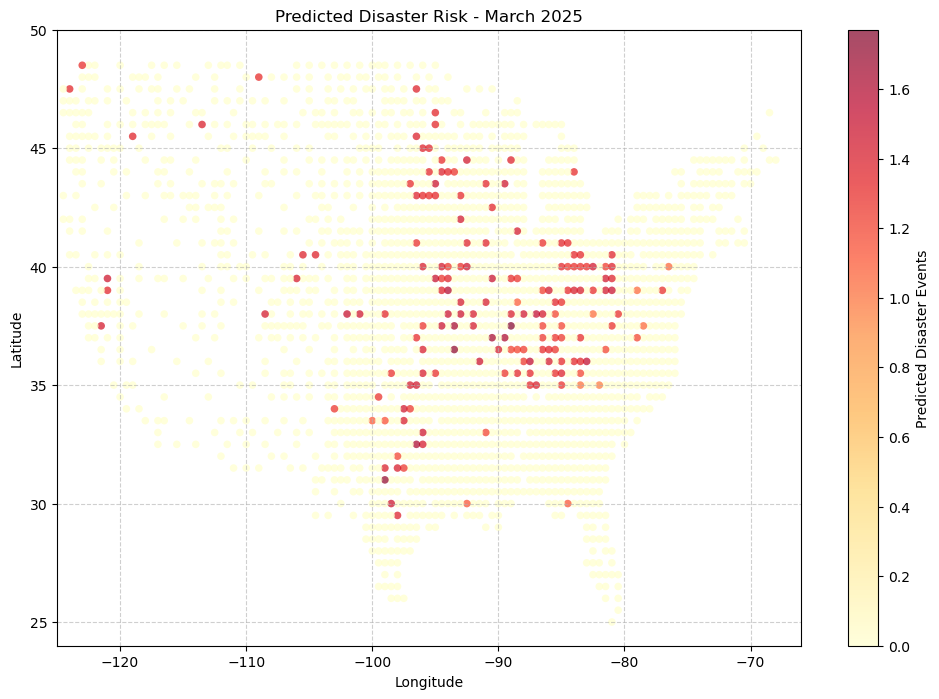

In [10]:
# Create risk heatmap
date_str = current_date.strftime('%B %Y')

# Create figure
plt.figure(figsize=(12, 8))

# Filter data for the US
plot_data = prediction_df.copy()
plot_data = plot_data[
    (plot_data['lat_grid'] >= 24) & 
    (plot_data['lat_grid'] <= 50) & 
    (plot_data['lng_grid'] >= -125) & 
    (plot_data['lng_grid'] <= -66)
]

# Create the scatter plot with predicted events
scatter = plt.scatter(
    plot_data['lng_grid'], 
    plot_data['lat_grid'],
    c=plot_data['predicted_events'],
    cmap='YlOrRd',
    alpha=0.7,
    s=30,
    edgecolors='none'
)

cbar = plt.colorbar(scatter)
cbar.set_label('Predicted Disaster Events')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Predicted Disaster Risk - {date_str}')

plt.xlim(-125, -66)
plt.ylim(24, 50)

plt.grid(True, linestyle='--', alpha=0.6)

output_dir = "gp_disaster_prediction_output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

map_path = os.path.join(output_dir, f"gp_disaster_risk_map_{current_date.strftime('%Y-%m')}.png")
plt.savefig(map_path, dpi=300, bbox_inches='tight')
print(f"Risk map saved to: {map_path}")

plt.show()

Uncertainty map saved to: gp_disaster_prediction_output/gp_uncertainty_map_2025-03.png


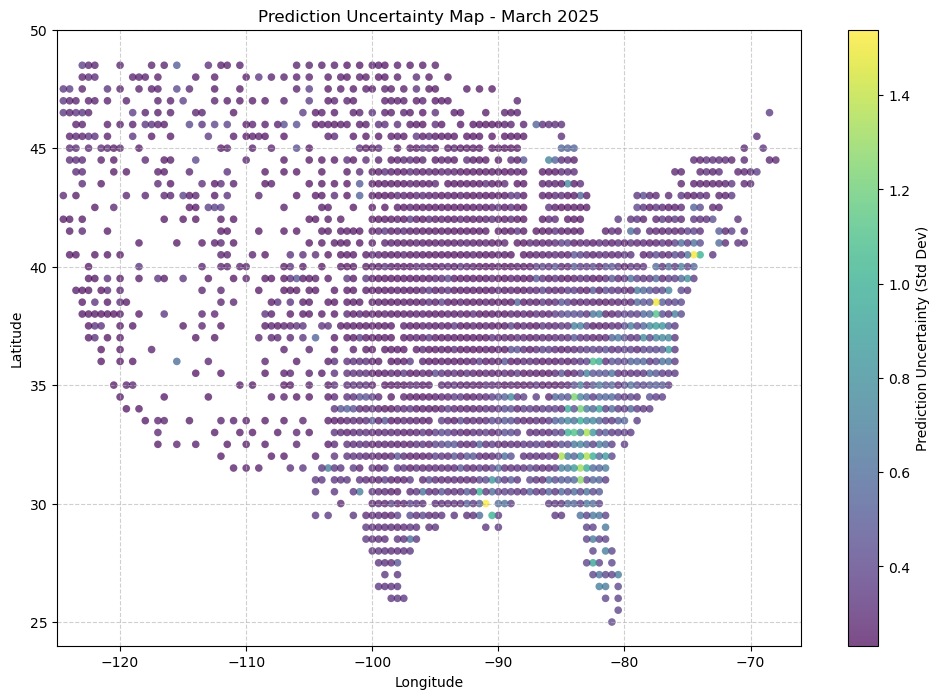

In [11]:
plt.figure(figsize=(12, 8))

# Filter data for the US
plot_data = prediction_df.copy()
plot_data = plot_data[
    (plot_data['lat_grid'] >= 24) & 
    (plot_data['lat_grid'] <= 50) & 
    (plot_data['lng_grid'] >= -125) & 
    (plot_data['lng_grid'] <= -66)
]

# Create the scatter plot with standard deviation
scatter = plt.scatter(
    plot_data['lng_grid'], 
    plot_data['lat_grid'],
    c=plot_data['prediction_std'],
    cmap='viridis',
    alpha=0.7,
    s=30,
    edgecolors='none'
)

cbar = plt.colorbar(scatter)
cbar.set_label('Prediction Uncertainty (Std Dev)')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Prediction Uncertainty Map - {date_str}')

plt.xlim(-125, -66)
plt.ylim(24, 50)

plt.grid(True, linestyle='--', alpha=0.6)

uncertainty_path = os.path.join(output_dir, f"gp_uncertainty_map_{current_date.strftime('%Y-%m')}.png")
plt.savefig(uncertainty_path, dpi=300, bbox_inches='tight')
print(f"Uncertainty map saved to: {uncertainty_path}")

plt.show()

In [14]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from IPython.display import HTML
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator

def create_accurate_animation():
    print("Creating animation with balanced GP predictions for all months...")
    
    # Set up figure with two panels
    fig = plt.figure(figsize=(16, 8))
    gs = gridspec.GridSpec(2, 2, height_ratios=[1, 10], width_ratios=[1, 1])
    
    title_ax = fig.add_subplot(gs[0, :])
    title_ax.axis('off')
    title_ax.text(0.5, 0.5, 'Disaster Events: Actual vs. Model Predictions', 
                 fontsize=20, fontweight='bold', ha='center', va='center')
    
    ax1 = fig.add_subplot(gs[1, 0])  # Actual data
    ax2 = fig.add_subplot(gs[1, 1])  # Predicted data
    
    ax1.set_title('Actual Historical Events', fontsize=16, pad=15)
    ax2.set_title('Gaussian Process Model Predictions', fontsize=16, pad=15)
    
    # Define the time period
    end_date = datetime.now()
    months_to_show = 12  # Last 12 months
    start_date = end_date - timedelta(days=months_to_show * 30)
    
    # Get historical data
    historic_data = grid_time_df[
        (grid_time_df['date'] >= start_date) & 
        (grid_time_df['date'] <= end_date)
    ].copy()
    
    # Get the current month predictions
    current_prediction = prediction_df.copy()
    
    # Get unique months for the animation
    historical_months = sorted(historic_data['yearmonth'].unique())
    
    # Create predictions for all historical months using the same GPR model
    monthly_predictions = {}
    
    # Store current month prediction
    monthly_predictions['Current'] = current_prediction
    
    # Generate predictions for each historical month
    for i, month in enumerate(historical_months):
        print(f"Generating predictions for historical month {i+1}/{len(historical_months)}: {month}")
        
        # Create a prediction dataframe for this historical month
        month_date = pd.to_datetime(month + "-01")
        month_pred_df = pd.DataFrame({
            'grid_id': grid_cells
        })
        
        # Extract grid coordinates
        month_pred_df = pd.merge(month_pred_df, grid_info, on='grid_id', how='left')
        
        # Add time features
        month_pred_df['yearmonth'] = month
        month_pred_df['date'] = month_date
        month_pred_df['year'] = month_date.year
        month_pred_df['month'] = month_date.month
        month_pred_df['day_of_year'] = month_date.timetuple().tm_yday
        
        # Add cyclical encoding of month
        month_pred_df['month_sin'] = np.sin(2 * np.pi * month_pred_df['month'] / 12)
        month_pred_df['month_cos'] = np.cos(2 * np.pi * month_pred_df['month'] / 12)
        
        # Add seasonal indicators
        month_pred_df['is_winter'] = ((month_pred_df['month'] == 12) | (month_pred_df['month'] == 1) | (month_pred_df['month'] == 2)).astype(int)
        month_pred_df['is_spring'] = ((month_pred_df['month'] == 3) | (month_pred_df['month'] == 4) | (month_pred_df['month'] == 5)).astype(int)
        month_pred_df['is_summer'] = ((month_pred_df['month'] == 6) | (month_pred_df['month'] == 7) | (month_pred_df['month'] == 8)).astype(int)
        month_pred_df['is_fall'] = ((month_pred_df['month'] == 9) | (month_pred_df['month'] == 10) | (month_pred_df['month'] == 11)).astype(int)
        
        # Create a cutoff date to ensure we only use data prior to this month for features
        cutoff_date = pd.to_datetime(month) - pd.DateOffset(days=1)
        historical_data_until_month = grid_time_df[grid_time_df['date'] <= cutoff_date].copy()
        
        if len(historical_data_until_month) == 0:
            print(f"  No historical data available before {month}, skipping...")
            # Just use empty predictions for this month
            month_pred_df['predicted_events'] = 0
            month_pred_df['prediction_std'] = 0
            month_pred_df['disaster_probability'] = 0
            monthly_predictions[month] = month_pred_df
            continue
            
        recent_data_for_month = historical_data_until_month.sort_values('yearmonth', ascending=False)
        
        # Get the historical features for each grid cell
        for grid_id in grid_cells:
            grid_data = recent_data_for_month[recent_data_for_month['grid_id'] == grid_id]
            
            if len(grid_data) == 0:
                continue
                
            latest_data = grid_data.iloc[0]
            
            # Add duration feature
            month_pred_df.loc[month_pred_df['grid_id'] == grid_id, 'incidentDurationInDays'] = latest_data['incidentDurationInDays']
            
            # Add historical features
            month_pred_df.loc[month_pred_df['grid_id'] == grid_id, 'event_count_hist1m'] = latest_data['event_count']
            month_pred_df.loc[month_pred_df['grid_id'] == grid_id, 'event_count_hist3m'] = (
                grid_data.iloc[:3]['event_count'].mean() if len(grid_data) >= 3 else latest_data['event_count']
            )
            month_pred_df.loc[month_pred_df['grid_id'] == grid_id, 'event_count_hist6m'] = (
                grid_data.iloc[:6]['event_count'].mean() if len(grid_data) >= 6 else latest_data['event_count']
            )
            month_pred_df.loc[month_pred_df['grid_id'] == grid_id, 'event_count_hist12m'] = (
                grid_data.iloc[:12]['event_count'].mean() if len(grid_data) >= 12 else latest_data['event_count']
            )
            
            # Find same month last year
            same_month_last_year = grid_data[
                (grid_data['month'] == month_date.month) & 
                (grid_data['year'] == month_date.year - 1)
            ]
            
            if len(same_month_last_year) > 0:
                month_pred_df.loc[month_pred_df['grid_id'] == grid_id, 'event_count_same_month_last_year'] = same_month_last_year.iloc[0]['event_count']
            else:
                month_pred_df.loc[month_pred_df['grid_id'] == grid_id, 'event_count_same_month_last_year'] = latest_data['event_count']
            
            # Add historical disaster type features
            for disaster_type in disaster_types:
                month_pred_df.loc[month_pred_df['grid_id'] == grid_id, f'disasterType_{disaster_type}_hist1m'] = latest_data[f'disasterType_{disaster_type}']
                
                for months_ago in [3, 6, 12]:
                    if len(grid_data) >= months_ago:
                        month_pred_df.loc[month_pred_df['grid_id'] == grid_id, f'disasterType_{disaster_type}_hist{months_ago}m'] = (
                            grid_data.iloc[:months_ago][f'disasterType_{disaster_type}'].mean()
                        )
                    else:
                        month_pred_df.loc[month_pred_df['grid_id'] == grid_id, f'disasterType_{disaster_type}_hist{months_ago}m'] = (
                            latest_data[f'disasterType_{disaster_type}']
                        )
        
        # Fill any remaining NaN values with 0
        month_pred_df = month_pred_df.fillna(0)
        
        # Make predictions using the model
        feature_cols = [
            # Spatial features
            'lat_grid', 'lng_grid',
            # Temporal features
            'month_sin', 'month_cos',
            # Duration feature
            'incidentDurationInDays',
            # Historical features
            'event_count_hist1m', 'event_count_hist3m', 'event_count_hist6m', 'event_count_hist12m',
            'event_count_same_month_last_year'
        ]
        
        # Add historical disaster type features
        for disaster_type in disaster_types:
            for months_ago in [1, 3, 6, 12]:
                feature_cols.append(f'disasterType_{disaster_type}_hist{months_ago}m')
        
        try:
            # Ensure we only select the features used in training
            X_pred = month_pred_df[feature_cols]
            X_scaled = scaler.transform(X_pred)
            
            # Apply feature selection before PCA
            if 'feature_selector' in globals() or 'feature_selector' in locals():
                X_selected = feature_selector.transform(X_scaled)
            else:
                X_selected = X_scaled
            
            # Apply PCA if it was used during training
            if pca is not None:
                X_transformed = pca.transform(X_selected)
            else:
                X_transformed = X_selected
            
            # Generate predictions with uncertainty
            pred_mean, pred_std = model.predict(X_transformed, return_std=True)
            month_pred_df['predicted_events'] = pred_mean
            month_pred_df['prediction_std'] = pred_std
            
            # Calculate confidence intervals
            month_pred_df['prediction_upper'] = pred_mean + 1.96 * pred_std
            month_pred_df['prediction_lower'] = np.maximum(0, pred_mean - 1.96 * pred_std)
            
            # Normalize predictions for probability interpretation
            pred_probs = pred_mean.copy()
            if max(pred_probs) > 1:
                pred_probs = pred_probs / max(1, max(pred_probs))
            month_pred_df['disaster_probability'] = pred_probs
            
            # For historical months, use balanced filtering criteria - not too strict, not too relaxed
            # Higher probability threshold
            month_pred_df.loc[month_pred_df['disaster_probability'] < 0.4, 'predicted_events'] = 0
            
            # Add confidence-based scaling with more reasonable threshold
            month_pred_df['confidence_factor'] = 1.0 / (1.0 + month_pred_df['prediction_std'])
            month_pred_df['predicted_events_scaled'] = month_pred_df['predicted_events'] * month_pred_df['confidence_factor']
            
            # Higher confidence threshold 
            min_confidence = 0.5
            month_pred_df.loc[month_pred_df['confidence_factor'] < min_confidence, 'predicted_events'] = 0
            month_pred_df.loc[month_pred_df['confidence_factor'] >= min_confidence, 'predicted_events'] = month_pred_df.loc[month_pred_df['confidence_factor'] >= min_confidence, 'predicted_events_scaled']
            
            # Filter by historical precedent with moderate strictness
            this_month_date = pd.to_datetime(month)
            two_years_before_month = (this_month_date - timedelta(days=730)).strftime('%Y-%m')
            
            # Recent historical events for this month (2 years prior)
            recent_historical_grid_cells_for_month = set(
                historical_data_until_month[
                    (historical_data_until_month['event_count'] > 0) & 
                    (historical_data_until_month['yearmonth'] >= two_years_before_month)
                ]['grid_id'].unique()
            )
            
            # Mark grid cells with historical precedent
            month_pred_df['has_recent_precedent'] = month_pred_df['grid_id'].isin(recent_historical_grid_cells_for_month)
            
            # Find adjacent cells
            all_grid_ids = set(month_pred_df['grid_id'])
            adjacent_to_recent_for_month = set()
            
            for grid_id in recent_historical_grid_cells_for_month:
                adjacent = find_adjacent_cells(grid_id, all_grid_ids)
                adjacent_to_recent_for_month.update(adjacent)
            
            month_pred_df['adjacent_to_recent'] = month_pred_df['grid_id'].isin(adjacent_to_recent_for_month)
            
            # More balanced criteria - require either recent historical precedent or high prediction value
            month_pred_df['keep_prediction'] = (
                (month_pred_df['has_recent_precedent']) |
                (month_pred_df['adjacent_to_recent'] & (month_pred_df['predicted_events'] > 0.8)) |
                (month_pred_df['predicted_events'] > 1.2)
            )
            
            # Apply the filter
            month_pred_df.loc[~month_pred_df['keep_prediction'], 'predicted_events'] = 0
            
            # Get the actual number of events for this month to set a reasonable number of predictions
            month_actual_data = historic_data[historic_data['yearmonth'] == month]
            actual_event_cells = len(month_actual_data[month_actual_data['event_count'] > 0])
            
            # Use a multiplier to set prediction limit (roughly 2x the actual events is reasonable)
            prediction_limit = max(30, actual_event_cells * 2)
            
            # If we have too many predictions, keep only the highest ones
            if len(month_pred_df[month_pred_df['predicted_events'] > 0]) > prediction_limit:
                top_preds = month_pred_df[month_pred_df['predicted_events'] > 0].nlargest(prediction_limit, 'predicted_events')
                month_pred_df['predicted_events'] = 0  # Reset all to zero
                month_pred_df.loc[top_preds.index, 'predicted_events'] = top_preds['predicted_events']
            
            # Ensure we have at least some predictions
            if len(month_pred_df[month_pred_df['predicted_events'] > 0]) < 10:
                # Get top 30 predictions by probability regardless of other criteria
                top_predictions = month_pred_df.nlargest(30, 'disaster_probability')
                min_predictions_to_show = min(30, len(top_predictions[top_predictions['disaster_probability'] > 0.3]))
                
                for idx in top_predictions.iloc[:min_predictions_to_show].index:
                    month_pred_df.loc[idx, 'predicted_events'] = pred_mean[idx]
            
            # Store the predictions for this month
            monthly_predictions[month] = month_pred_df
            
            print(f"  Created predictions for {month} - {len(month_pred_df[month_pred_df['predicted_events'] > 0])} cells with non-zero predictions")
            
        except Exception as e:
            print(f"  Error generating predictions for {month}: {str(e)}")
            # Use empty predictions
            month_pred_df['predicted_events'] = 0
            month_pred_df['prediction_std'] = 0
            month_pred_df['disaster_probability'] = 0
            monthly_predictions[month] = month_pred_df
    
    # Get geographical boundaries for continental US
    min_lat = 24  # Southern US
    max_lat = 50  # Northern US
    min_lng = -125  # West Coast
    max_lng = -66  # East Coast
    
    # Set the same limits for both plots
    for ax in [ax1, ax2]:
        ax.set_xlim(min_lng, max_lng)
        ax.set_ylim(min_lat, max_lat)
        ax.set_aspect('equal')
        ax.grid(alpha=0.3)
        ax.set_xlabel('Longitude', fontsize=12)
        ax.set_ylabel('Latitude', fontsize=12)
        ax.xaxis.set_major_locator(MaxNLocator(5))
        ax.yaxis.set_major_locator(MaxNLocator(5))
        ax.tick_params(axis='both', which='major', labelsize=10)
    
    def add_us_states(ax):
        # Vertical state lines
        for lng in [-124, -120, -114, -111, -104, -96, -90, -84, -80, -76, -72]:
            ax.axvline(lng, color='gray', linestyle='-', linewidth=0.5, alpha=0.3)
        # Horizontal state lines
        for lat in [26, 30, 33, 36, 39, 42, 45, 49]:
            ax.axhline(lat, color='gray', linestyle='-', linewidth=0.5, alpha=0.3)
        
        # Add US outline
        # East Coast
        ax.plot([-67, -70, -75, -80, -82, -83, -85, -87, -90, -93, -97], 
               [47, 42, 37, 31, 28, 26, 26, 30, 29, 28, 28], 
               color='blue', linestyle='-', linewidth=1, alpha=0.5)
        
        # West Coast
        ax.plot([-125, -124, -120, -117, -115], 
               [48, 42, 37, 33, 32], 
               color='blue', linestyle='-', linewidth=1, alpha=0.5)
    
    add_us_states(ax1)
    add_us_states(ax2)
    
    # Create custom colormaps
    actual_cmap = plt.cm.Blues
    pred_cmap = plt.cm.Oranges
    
    # Initialize scatter plots
    scatter1 = ax1.scatter([], [], c=[], cmap=actual_cmap, s=100, alpha=0.8, vmin=0, vmax=3, edgecolor='black', linewidth=0.5)
    scatter2 = ax2.scatter([], [], c=[], cmap=pred_cmap, s=100, alpha=0.8, vmin=0, vmax=3, edgecolor='black', linewidth=0.5)
    
    # Add colorbars
    cbar1 = fig.colorbar(scatter1, ax=ax1, orientation='vertical', pad=0.01)
    cbar1.set_label('Actual Event Count', fontsize=12)
    
    cbar2 = fig.colorbar(scatter2, ax=ax2, orientation='vertical', pad=0.01)
    cbar2.set_label('Predicted Event Count', fontsize=12)
    
    # Add month display
    month_text = title_ax.text(0.5, 0.0, '', fontsize=16, fontweight='bold', ha='center')
    
    # Add metrics display
    metrics_props = dict(boxstyle='round', facecolor='wheat', alpha=0.9, edgecolor='brown', pad=0.7)
    metrics_text = ax2.text(0.5, 0.05, '', transform=ax2.transAxes, fontsize=12, ha='center',
                           bbox=metrics_props)
    
    # List of months for animation (historical + current)
    all_months = historical_months + ['Current']
    
    # Function to update the animation
    def update(frame):
        month = all_months[frame]
        
        if month == 'Current':
            display_month = f"Current Month: {end_date.strftime('%Y-%m')}"
            is_current = True
        else:
            display_month = f"Historical Month: {month}"
            is_current = False
            
        month_text.set_text(display_month)
        
        # Update actual events (left plot)
        if not is_current:
            # For historical months, show actual data
            month_data = historic_data[historic_data['yearmonth'] == month]
            
            actual_lats = []
            actual_lngs = []
            actual_vals = []
            
            for _, row in month_data.iterrows():
                if row['event_count'] > 0:
                    actual_lats.append(row['lat_grid'])
                    actual_lngs.append(row['lng_grid'])
                    actual_vals.append(row['event_count'])
            
            scatter1.set_offsets(np.column_stack([actual_lngs, actual_lats]) if actual_lats else np.empty((0, 2)))
            scatter1.set_array(np.array(actual_vals) if actual_vals else np.array([]))
            
            # Show actual GP predictions for this historical month
            month_pred = monthly_predictions[month]
            
            pred_lats = []
            pred_lngs = []
            pred_vals = []
            
            for _, row in month_pred.iterrows():
                if row['predicted_events'] > 0:
                    pred_lats.append(row['lat_grid'])
                    pred_lngs.append(row['lng_grid'])
                    pred_vals.append(row['predicted_events'])
            
            scatter2.set_offsets(np.column_stack([pred_lngs, pred_lats]) if pred_lngs else np.empty((0, 2)))
            scatter2.set_array(np.array(pred_vals) if pred_vals else np.array([]))
            
            # Calculate accuracy metrics for this month
            actual_points = set((round(row['lat_grid'], 1), round(row['lng_grid'], 1)) 
                              for _, row in month_data.iterrows() if row['event_count'] > 0)
            pred_points = set((round(row['lat_grid'], 1), round(row['lng_grid'], 1)) 
                            for _, row in month_pred.iterrows() if row['predicted_events'] > 0)
            
            # Calculate overlap
            overlap = actual_points.intersection(pred_points)
            if actual_points:
                accuracy = len(overlap) / len(actual_points) * 100
                metrics_text.set_text(f'GP Model Accuracy: {accuracy:.1f}%\n'
                                    f'Actual: {len(actual_points)}, Predicted: {len(pred_points)}')
            else:
                metrics_text.set_text('No actual events in this month')
            
            ax1.set_title('Actual Historical Events', fontsize=16)
            ax2.set_title('GP Model Historical Predictions', fontsize=16)
            
        else:
            # For current month, show most recent month's actual data as reference
            recent_month = historical_months[-1] if historical_months else None
            if recent_month:
                recent_data = historic_data[historic_data['yearmonth'] == recent_month]
                
                actual_lats = []
                actual_lngs = []
                actual_vals = []
                
                for _, row in recent_data.iterrows():
                    if row['event_count'] > 0:
                        actual_lats.append(row['lat_grid'])
                        actual_lngs.append(row['lng_grid'])
                        actual_vals.append(row['event_count'])
                
                scatter1.set_offsets(np.column_stack([actual_lngs, actual_lats]) if actual_lats else np.empty((0, 2)))
                scatter1.set_array(np.array(actual_vals) if actual_vals else np.array([]))
            else:
                scatter1.set_offsets(np.empty((0, 2)))
                scatter1.set_array(np.array([]))
            
            # Show the GP model prediction for the current month
            current_pred = monthly_predictions['Current']
            
            pred_lats = []
            pred_lngs = []
            pred_vals = []
            
            for _, row in current_pred.iterrows():
                if row['predicted_events'] > 0:
                    pred_lats.append(row['lat_grid'])
                    pred_lngs.append(row['lng_grid'])
                    pred_vals.append(row['predicted_events'])
            
            scatter2.set_offsets(np.column_stack([pred_lngs, pred_lats]) if pred_lngs else np.empty((0, 2)))
            scatter2.set_array(np.array(pred_vals) if pred_vals else np.array([]))
            
            # Add note about the model's current prediction
            filtered_percent = len(pred_lats) / len(current_pred) * 100
            metrics_text.set_text(f'Gaussian Process Prediction\n'
                                 f'{len(pred_lats)} cells ({filtered_percent:.1f}%)')
                                 
            ax1.set_title('Most Recent Historical Month', fontsize=16)
            ax2.set_title('Current Month GP Prediction', fontsize=16)
        
        return scatter1, scatter2, month_text, metrics_text
    
    # Create animation
    ani = animation.FuncAnimation(
        fig, update, frames=len(all_months),
        interval=2000, blit=False
    )
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    plt.close(fig)
    
    return ani

# Create the animation
ani = create_accurate_animation()

# Display the animation in the notebook
html_animation = HTML(ani.to_jshtml())
display(html_animation)

# Save as GIF (optional)
try:
    ani.save('disaster_comparison.gif', writer='pillow', fps=0.5, dpi=100)
    print("Animation saved as 'disaster_comparison.gif'")
except Exception as e:
    print(f"Could not save GIF due to: {str(e)}")
    print("Animation is still viewable in the notebook.")

Creating animation with balanced GP predictions for all months...
Generating predictions for historical month 1/8: 2024-04
  Created predictions for 2024-04 - 306 cells with non-zero predictions
Generating predictions for historical month 2/8: 2024-05
  Created predictions for 2024-05 - 306 cells with non-zero predictions
Generating predictions for historical month 3/8: 2024-06
  Created predictions for 2024-06 - 212 cells with non-zero predictions
Generating predictions for historical month 4/8: 2024-07
  Created predictions for 2024-07 - 158 cells with non-zero predictions
Generating predictions for historical month 5/8: 2024-08
  Created predictions for 2024-08 - 348 cells with non-zero predictions
Generating predictions for historical month 6/8: 2024-09
  Created predictions for 2024-09 - 391 cells with non-zero predictions
Generating predictions for historical month 7/8: 2024-10
  Created predictions for 2024-10 - 78 cells with non-zero predictions
Generating predictions for histo

Animation saved as 'disaster_comparison.gif'
